## read the pickel files for a given genome from the fasta and the illumina files:

### fasta:    dictionary of the format: fasta_dict[locus][kmer]=appearance
### illumina: dictionary of format illumina: illumina_dict[locus][kmer]=appearance


In [1]:
import pickle
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
from termcolor import colored
import matplotlib.pyplot as plt
import statsmodels.api as sm
from operator import itemgetter



In [2]:
# save pickle file:
def save_pickle(file, mydict):
    genomes = list(mydict.keys())
    for genome in genomes:
        with open('{}'.format(file), 'wb') as f:
            pickle.dump(mydict, f)


# read pickle file:
def read_pickle(path, file):
    start_time = datetime.now()
    with open('{}{}'.format(path, file), 'rb') as f:
        print('Read pickle file ...  {}'.format(file), end='')
        loaded_dict = pickle.load(f)
        print('     Duration: {}'.format(datetime.now()-start_time))
    return loaded_dict

# read the genome list form genomes.HPRC.txt
def read_genome_list(path, file_genomes):
    file_genomes = '{}{}'.format(path, genomes_file)
    genome_list = []
    genome_cnt = 0
    with open(file_genomes,'r') as f:
        while True:
            genome_cnt += 1
            if genome_cnt == -99+1:
                break
            genome = f.readline().rstrip()
            if genome == '':
                break
            genome_list.append(genome)    
    return genome_list


# read the orthoMap:
def read_orthoMap():
    path = '/Users/tkroll/Dropbox/uni_dropbox/Courses/bioinformatics_USC/bias-correction/50008/'
    file = '{}OrthoMap.v2.tsv'.format(path)
    
    df = pd.read_csv(file,sep='\t', header=None)
    df = df.replace('.', 'NaN')

    orthoMap = np.array(df)
    return orthoMap

          
def read_fasta_illumina(path, genome):
    illumina = dict()
    file = 'kmer_appearance_{}.pkl'.format(genome)
    file = 'illumina_dict_{}.pkl'.format(genome)
    illumina = read_pickle(path, file)

    fasta = dict()
    if len(illumina.keys()) > 0:
        file = 'fasta_dict_{}.pkl'.format(genome)
        fasta = read_pickle(path, file)

    return fasta, illumina


## aln-r2:

In [3]:
def aln_r2(path, genomes):
    # create a matrix of size N_loci, N_sample, same as orthoMap
    orthoMap = read_orthoMap()
    aln_r2_statistic = np.empty((orthoMap.shape[0], int(orthoMap.shape[1]/2)))
    aln_r2_statistic[:] = np.nan
    aln_r2_pvalue = np.copy(aln_r2_statistic)
    aln_r2_sm = np.copy(aln_r2_statistic)
    aln_r2_adjusted_sm = np.copy(aln_r2_statistic)
    aln_r2_sm_ac = np.copy(aln_r2_statistic)
    aln_r2_adjusted_sm_ac = np.copy(aln_r2_statistic)
    
    error = 0
    for i, genome in enumerate(genomes):
        #print('Genome: {}'.format(genome))
        print(colored('Genome {}             ({}/{})'.format(genome, i+1, len(genomes)), 'green'))
        fasta, illumina = read_fasta_illumina(path, genome)
        
        start_time = datetime.now()
        print('fill the aln_r2_matrix column ...')
        if len(illumina.keys()) > 0:
            for j, locus in enumerate(fasta.keys()):
                x = []
                y = []
                # (i) check that the fasta kmers are a subset of the illumina kmers:
                # fasta[locus][kmer]=appearance
                fasta_kmers = list(fasta[locus].keys())
                # illumina[locus][kmer]=appearance
                illumina_kmers = list(illumina[locus].keys())
                if not set(fasta_kmers).issubset(illumina_kmers):
                    print("Error!! The fasta kmers are not a subset of the illumina kmers!!")
                    error = 1
                else:
                    for kmer in fasta_kmers:
                        x.append(fasta[locus][kmer])
                        y.append(illumina[locus][kmer])
                        
                # determine the Pearson's r for this genome and locus 
                # (i) add a (0,0) to avoid a non-definition of Pearson's r
                x.append(0)
                y.append(0)
                # (ii) calculate Pearson's r. If the length is too low (i.e. < 2) ignore.
                if len(x) > 2 and len(y) > 2 and sum(x) > 0 and sum(y) > 0:
                    # calculate the R2 value using stats.pearsonr:
                    pearsonr = stats.pearsonr(x, y)
                    aln_r2_statistic[locus,i] = np.square(pearsonr[0])
                    aln_r2_pvalue[locus,i] = pearsonr[1]
                    # calculate the R2 value using statsmodels:
                    sm_results = sm.OLS(y, x).fit()
                    aln_r2_sm[locus,i] = sm_results.rsquared
                    aln_r2_adjusted_sm[locus,i] = sm_results.rsquared_adj
                    # calculate the R2 value using statsmodels with add_constant, 
                    # i.e. we do not force the model to go through the origin:
                    x_ = sm.add_constant(x)
                    sm_results = sm.OLS(y, x_).fit()
                    aln_r2_sm_ac[locus,i] = sm_results.rsquared
                    aln_r2_adjusted_sm_ac[locus,i] = sm_results.rsquared_adj
                if j % 10 == 0:
                    print('\r', '  Locus count', j, 'out of', len(fasta.keys()), end='')
            print()
        
        else:
            print('  No Illumina file exists for genome {}.'.format(genome))

                    
        print('    duration for genome {}: {}'.format(genome, datetime.now()-start_time))
    
    return aln_r2_statistic, aln_r2_pvalue, aln_r2_sm, aln_r2_adjusted_sm, aln_r2_sm_ac, aln_r2_adjusted_sm_ac
    
    

In [4]:
# file that contains all genomes:
path = '/Users/tkroll/Dropbox/uni_dropbox/Courses/bioinformatics_USC/bias-correction/50008/'
genomes_file = 'genomes.HPRC.txt'
genomes = read_genome_list(path, genomes_file)
#genomes = ['HG002', 'HG00438']

# create the aln-r2 matrix:
start_time_total = datetime.now()
path = '/Users/tkroll/Dropbox/uni_dropbox/Courses/bioinformatics_USC/bias-correction/50008/files/'
aln_r2_statistic, aln_r2_pvalue, aln_r2_sm, aln_r2_adjusted_sm, aln_r2_sm_ac, aln_r2_adjusted_sm_ac = aln_r2(path, genomes)

print('\n--- Total time for calculation of all genomes: {}'.format(datetime.now()-start_time_total))

# save the Pearson's R matrices for the statiscic and pvalue:
start_time = datetime.now()
print('\nSave R matrices  ...', end='')

# Pearson's R2 results for the statiscic and pvalue:
file = '{}aln-r2_statistic.txt'.format(path)
np.savetxt(file, aln_r2_statistic)
file = '{}aln-r2_pvalue.txt'.format(path)
np.savetxt(file, aln_r2_pvalue)

# statsmodels for R2 and R2_adjusted (it seems that it is more important for more than two variables)
file = '{}aln-r2_sm.txt'.format(path)
np.savetxt(file, aln_r2_sm)
file = '{}aln-r2_adjusted_sm.txt'.format(path)
np.savetxt(file, aln_r2_adjusted_sm)

# statsmodels for R2 and R2_adjusted including add_constant
file = '{}aln-r2_sm_ac.txt'.format(path)
np.savetxt(file, aln_r2_sm_ac)
file = '{}aln-r2_adjusted_sm_ac.txt'.format(path)
np.savetxt(file, aln_r2_adjusted_sm_ac)

print('   Done    ({})'.format(datetime.now()-start_time))


Genome HG002             (1/48)
Read pickle file ...  illumina_dict_HG002.pkl     Duration: 0:00:00.005076
fill the aln_r2_matrix column ...
  No Illumina file exists for genome HG002.
    duration for genome HG002: 0:00:00.000009
Genome HG00438             (2/48)
Read pickle file ...  illumina_dict_HG00438.pkl     Duration: 0:00:01.661062
Read pickle file ...  fasta_dict_HG00438.pkl     Duration: 0:00:03.280755
fill the aln_r2_matrix column ...
   Locus count 23800 out of 23805
    duration for genome HG00438: 0:01:12.529417
Genome HG005             (3/48)
Read pickle file ...  illumina_dict_HG005.pkl     Duration: 0:00:00.002108
fill the aln_r2_matrix column ...
  No Illumina file exists for genome HG005.
    duration for genome HG005: 0:00:00.000540
Genome HG00621             (4/48)
Read pickle file ...  illumina_dict_HG00621.pkl     Duration: 0:00:01.525536
Read pickle file ...  fasta_dict_HG00621.pkl     Duration: 0:00:03.000415
fill the aln_r2_matrix column ...
   Locus count 234

Read pickle file ...  illumina_dict_HG02559.pkl     Duration: 0:00:00.001014
fill the aln_r2_matrix column ...
  No Illumina file exists for genome HG02559.
    duration for genome HG02559: 0:00:00.000007
Genome HG02572             (30/48)
Read pickle file ...  illumina_dict_HG02572.pkl     Duration: 0:00:01.388449
Read pickle file ...  fasta_dict_HG02572.pkl     Duration: 0:00:02.806875
fill the aln_r2_matrix column ...
   Locus count 23170 out of 23174
    duration for genome HG02572: 0:01:21.782254
Genome HG02622             (31/48)
Read pickle file ...  illumina_dict_HG02622.pkl     Duration: 0:00:01.399736
Read pickle file ...  fasta_dict_HG02622.pkl     Duration: 0:00:03.155665
fill the aln_r2_matrix column ...
   Locus count 23800 out of 23809
    duration for genome HG02622: 0:01:21.104671
Genome HG02630             (32/48)
Read pickle file ...  illumina_dict_HG02630.pkl     Duration: 0:00:01.375283
Read pickle file ...  fasta_dict_HG02630.pkl     Duration: 0:00:02.609484
fill 

In [5]:
# read the R2 matrices
path = '/Users/tkroll/Dropbox/uni_dropbox/Courses/bioinformatics_USC/bias-correction/50008/'

# Pearson"s R
file = '{}aln-r2_statistic.txt'.format(path)
R2_stats = np.loadtxt(file)
print(R2_stats.shape)

## statsmodels:
#file = '{}aln-r2_sm.txt'.format(path)
#R2_sm = np.loadtxt(file)
#file = '{}aln-r2_adjusted_sm.txt'.format(path)
#R2_adj_sm = np.loadtxt(file)
#
## statsmodels with add_constant:
#file = '{}aln-r2_sm_ac.txt'.format(path)
#R2_sm_ac = np.loadtxt(file)
#file = '{}aln-r2_adjusted_sm_ac.txt'.format(path)
#R2_adj_sm_ac = np.loadtxt(file)
#

(23956, 48)


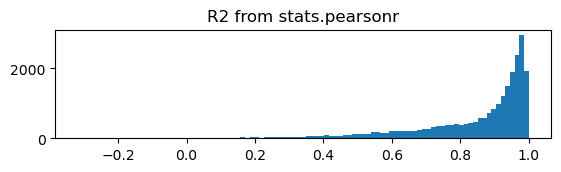

In [6]:
# plot the three aln-R2 results:

R2_stats_ave_per_locus = np.nanmean(R2_stats, axis=1)
plt.subplot(311)
plt.hist(R2_stats_ave_per_locus, bins='auto')
plt.title("R2 from stats.pearsonr")

#R2_sm_ave_per_locus = np.nanmean(R2_sm, axis=1)
#plt.subplot(312)
#plt.hist(R2_sm_ave_per_locus, bins='auto')
#plt.title("R2 from statsmodels")
#
#R2_sm_ac_ave_per_locus = np.nanmean(R2_sm_ac, axis=1)
#plt.subplot(313)
#plt.hist(R2_sm_ac_ave_per_locus, bins='auto')
#plt.title("R2 from statsmodels with add_constant")

plt.show()


## Locus batch-r2

In [ ]:
import pickle 
def locus_batch_r2(path, genomes):
    # create a nan array of the sice of orthoMap
    # two consecutive solumns per genome
    # the first column contains the number of the summed appearances in fasta, the second in Illumina
    # 
    orthoMap = read_orthoMap()
    batch_r2_appearances = np.empty((orthoMap.shape[0], int(orthoMap.shape[1])))
    batch_r2_appearances[:]=np.nan
    
    for g, genome in enumerate(genomes):
        print(colored('Genome: {}      ({}/{})'.format(genome, g, len(genomes)), 'green'))

        # read the fasta and illumina dictionaries:
        fasta, illumina = read_fasta_illumina(path, genome)
        
        # go through the illumina dictionary:
        if len(illumina.keys())>0:
            for i, locus in enumerate(fasta.keys()):
                # add the appearances of all kmers at this locus:
                app = 0
                for kmer, appearance in illumina[locus].items():
                    app += appearance
                # write fasta kmer appearance into atrix:
                batch_r2_appearances[locus, g*2+1] = appearance


            # go through the fasta dictionary:
            for i, locus in enumerate(fasta.keys()):
                # add the appearances of all kmers at this locus:
                app = 0
                for kmer, appearance in fasta[locus].items():
                    app += appearance
                # write fasta kmer appearance into atrix:
                batch_r2_appearances[locus, g*2] = appearance
    
    return batch_r2_appearances

def locus_batch_r2_calc(batch_r2_appearances):
    # create 2d array with length of all loci and 2 rows (statistic and pvalue):
    batch_r2_vector = np.empty((batch_r2_appearances.shape[0], 3))
    batch_r2_vector[:] = np.nan
    
    for i in range(batch_r2_appearances.shape[0]):
        # x-vector including nan are all even columns
        xx = batch_r2_appearances[i,::2]
        # y-vector including nan are all odd columns
        yy = batch_r2_appearances[i,1::2]
        
        # erase the nan values to get the x and y vectors
        x = xx[np.isfinite(xx) & np.isfinite(yy)]
        y = yy[np.isfinite(xx) & np.isfinite(yy)]
        
        # add a 0 to each vector
        x = np.append(x, 0)
        y = np.append(y, 0)
        
        # calculate the Pearson's R correlation:
        if len(x)>2 and len(y)>2 and np.sum(x)>0 and np.sum(y)>0:
            # Pearson's R (that's the one for locus batch R2):
            PearsonsR = stats.pearsonr(x, y)
            batch_r2_vector[i,0] = np.square(PearsonsR[0])
            
            # statsmodels
            sm_results = sm.OLS(y, x).fit()
            batch_r2_vector[i,1] = sm_results.rsquared
            # calculate the R2 value using statsmodels with add_constant, 
            # i.e. we do not force the model to go through the origin:
            x_ = sm.add_constant(x)
            sm_results = sm.OLS(y, x_).fit()
            batch_r2_vector[i,2] = sm_results.rsquared
            
    
    return batch_r2_vector
    
    
    

In [ ]:
# file that contains all genomes:
path = '/Users/tkroll/Dropbox/uni_dropbox/Courses/bioinformatics_USC/bias-correction/50008/'
genomes_file = 'genomes.HPRC.txt'
genomes = read_genome_list(path, genomes_file)
#genomes = ['HG00438']

# create the batch-r2 matrix:
start_time_total = datetime.now()
path = '/Users/tkroll/Dropbox/uni_dropbox/Courses/bioinformatics_USC/bias-correction/50008/files/'

start_time = datetime.now()
batch_r2_appearances = locus_batch_r2(path, genomes)
print('  batch_r2 appearance: {}\n'.format(datetime.now()-start_time))

start_time = datetime.now()
batch_r2_vector = locus_batch_r2_calc(batch_r2_appearances)
print('  batch_r2 matrix: {}'.format(datetime.now()-start_time))

print('\n  complete batch_r2 duration: {}'.format(datetime.now()-start_time_total))


# save the batch-r2 matrix:
print('Save the batch-r2 matrix   ...    ', end='')
start_time = datetime.now()
file = '{}locus_batch-r2.txt'.format(path)
np.savetxt(file, batch_r2_vector)
print('   Done    ({})'.format(datetime.now()-start_time))




In [ ]:
# read the batch-r2 matrix:
file = '{}locus_batch-r2.txt'.format(path)
batch_r2 = np.loadtxt(file)


In [ ]:
for i in range(3):
    if i == 0: 
        # plot the Pearson R values of R2 vs locus:
        yy = batch_r2[:,0]
    elif i == 1: 
        # plot the R2 value from statsmodels vs locus:
        yy = batch_r2[:,1]
    elif i == 2: 
        # plot the R2 value from statsmodels with add_constant vs locus:
        yy = batch_r2[:,2]

        
    plt.subplot(311)
    plt.plot(yy, '.', markersize=1)
    plt.xlabel('locus')
    plt.ylabel('R2')

    plt.subplot(312)
    plt.hist(yy, bins='auto')
    plt.ylim([0,1750])
    plt.xlabel('R2 valeus')

#    plt.subplot(313)
#    ys = np.sort(yy)
#    xs=np.arange(yy.size)
#    plt.plot(xs, ys, '.')
    
    plt.show()
    #plt.close()



In [28]:
aa = np.empty((1,4))
aa[:]=np.nan
print(aa)
aa = np.append(aa, np.empty((1,4)), axis=0)
print(aa)
aa[-1,:]=2
print(aa)
aa[-1,:]=np.nan
print(aa)


[[nan nan nan nan]]
[[nan nan nan nan]
 [ 2.  2.  2.  2.]]
[[nan nan nan nan]
 [ 2.  2.  2.  2.]]
[[nan nan nan nan]
 [nan nan nan nan]]


## kmer- batch-r2

In [2]:
def add_to_matrices(n_genomes, counter, genome_index, fasta_kmer_count, illumina_kmer_count, fasta_matrix, illumina_matrix):

    fasta_matrix[counter,genome_index] = fasta_kmer_count
    fasta_matrix = np.append(fasta_matrix, np.empty((1,n_genomes)), axis=0)
    fasta_matrix[-1,:] = np.nan
    
    illumina_matrix[counter,genome_index] = illumina_kmer_count
    illumina_matrix = np.append(illumina_matrix, np.empty((1,n_genomes)), axis=0)
    illumina_matrix[-1,:] = np.nan
    
    return fasta_matrix, illumina_matrix

def create_lookup_dict(path, genomes):
    
    lookup_dict = {}
    counter = 0

    for g, genome in enumerate(genomes):
        print(colored('Genome: {}      ({}/{})'.format(genome, g+1, len(genomes)), 'green'))

        # read the fasta and illumina dictionaries:
        fasta, illumina = read_fasta_illumina(path, genome)

        # go through the illumina dictionary:
        if len(illumina.keys())>0:
            start_time_1 = datetime.now()
            
            # go through the loci:
            for locus in fasta.keys():
                # check if locus has already been visited
                if locus not in lookup_dict.keys():
                    lookup_dict[locus] = dict()
                    # go through the kmers at that locus:
                    for kmer in fasta[locus].keys():
                        # since locus is new, all locus/kmer combinations are new too:
                        lookup_dict[locus][kmer] = counter
                        counter += 1
                        
                else:  # locus is in lookup dictionary
                    # go through the kmers at that locus:
                    for kmer in fasta[locus].keys():
                        if kmer not in lookup_dict[locus].keys():
                            lookup_dict[locus][kmer] = counter
                            counter += 1                
                    
            print('Done.   ({})'.format(datetime.now()-start_time_1))
        else:
            print('   Illumina file does not exist. Skip.')
        
    return lookup_dict
        
def kmer_batch_r2_matrix(path, genomes):

    n_genomes = len(genomes)

    fasta_matrix = np.empty((1,n_genomes))
    fasta_matrix[:]=np.nan
    illumina_matrix = np.empty((1,n_genomes))
    illumina_matrix[:]=np.nan
    
    counter = 0
    lookup_dict = {}
    
    for g, genome in enumerate(genomes):
        print(colored('Genome: {}      ({}/{})'.format(genome, g+1, len(genomes)), 'green'))

        # read the fasta and illumina dictionaries:
        fasta, illumina = read_fasta_illumina(path, genome)

        # go through the illumina dictionary:
        if len(illumina.keys())>0:
            start_time_1 = datetime.now()
            
            # go through the loci:
            for locus in fasta.keys():
                # check if locus has already been visited
                if locus not in lookup_dict.keys():
                    lookup_dict[locus] = dict()
                    # go through the kmers at that locus:
                    for kmer in fasta[locus].keys():
                        # since locus is new, all locus/kmer combinations are new too:
                        lookup_dict[locus][kmer] = counter
                        fasta_matrix, illumina_matrix = add_to_matrices(n_genomes, counter, g, fasta[locus][kmer], illumina[locus][kmer], fasta_matrix, illumina_matrix)
                        counter += 1
                        
                else:  # locus is in lookup dictionary
                    # go through the kmers at that locus:
                    for kmer in fasta[locus].keys():
                        if kmer not in lookup_dict[locus].keys():
                            lookup_dict[locus][kmer] = counter
                            fasta_matrix, illumina_matrix = add_to_matrices(n_genomes, counter, g, fasta[locus][kmer], illumina[locus][kmer], fasta_matrix, illumina_matrix)
                            counter += 1

                        else:   # locus/kmer already exists in dict
                            row = lookup_dict[locus][kmer]
                            fasta_matrix[row,g] = fasta[locus][kmer]
                            illumina_matrix[row,g] = illumina[locus][kmer]
                
                    
            print('Done.   ({})'.format(datetime.now()-start_time_1))
        else:
            print('   Illumina file does not exist. Skip.')

            
            
            

def kmer_batch_r2_dict(path, genomes):
    # create a nan array of the sice of orthoMap
    # two consecutive solumns per genome
    # the first column contains the number of the summed appearances in fasta, the second in Illumina
    # 
    orthoMap = read_orthoMap()
    batch_r2_appearances = np.empty((orthoMap.shape[0], int(orthoMap.shape[1])))
    batch_r2_appearances[:]=np.nan
    
    # For each genome, go throgh each locus and create a dictionary with kmer as keys and appearance as values. 
    # If a kmers already exists as a key, add the value.
    illumina_R2_dict = {}
    fasta_R2_dict = {}
    
    # fill in the key values with loci:
    for locus in range(23956):
        illumina_R2_dict[locus] = {}
        fasta_R2_dict[locus] = {}
    
    for g, genome in enumerate(genomes):
        print(colored('Genome: {}      ({}/{})'.format(genome, g+1, len(genomes)), 'green'))

        # read the fasta and illumina dictionaries:
        fasta, illumina = read_fasta_illumina(path, genome)
        
        # go through the illumina dictionary:
        if len(illumina.keys())>0:
            # strategy:
            # illumina_R2_dict[locus][kmer]=[list of kmer-counts in all genomes, 0] = y
            # fasta_R2_dict[locus][kmer]=[list of kmer-counts in all genomes, 0] = x
            # Note: the fasta loci and kmers are subsets of the illumina, hence loop only over the fasta loci
            
            start_time_1 = datetime.now()
            print('   Fill the kmer-R2 dictionaries  ...    ', end='')
            # go through the loci:
            for locus in fasta.keys():
                # go through the kmers at that locus:
                for kmer in fasta[locus].keys():
                    if kmer not in illumina_R2_dict[locus].keys():
                        illumina_R2_dict[locus][kmer]=[illumina[locus][kmer]]
                        fasta_R2_dict[locus][kmer]=[fasta[locus][kmer]]
                    else:
                        illumina_R2_dict[locus][kmer].append(illumina[locus][kmer])
                        fasta_R2_dict[locus][kmer].append(fasta[locus][kmer])
                        
            print('Done.   ({})'.format(datetime.now()-start_time_1))
        else:
            print('   Illumina file does not exist. Skip.')
            
    return illumina_R2_dict, fasta_R2_dict
            
    
# Save dictionaries into smaller files
def save_kmer_R2_dict(illumina_R2_dict, fasta_R2_dict, path):

    print(colored('save the kmer-R2 dictionaries ...','green'))
    n = len(illumina_R2_dict.keys())
    start = 0
    num = 500
    for i in range(n):
        if (i+1) % num == 0 and i < num+1:
            # get subset of dictionary:
            keys_to_extract = set(np.arange(start,i+1))
            illumina_subset_dict = dict(zip(keys_to_extract, itemgetter(*keys_to_extract)(illumina_R2_dict)))
            fasta_subset_dict = dict(zip(keys_to_extract, itemgetter(*keys_to_extract)(fasta_R2_dict)))
        
            print(len(illumina_subset_dict.keys()))
            print(list(illumina_subset_dict.keys())[0:6])
        
            # save the dictionaries as pickle files:
            file = 'kmer_R2_dict_illumina_{}-{}.pkl'.format(start, i)
            print('   Save illumina loci {}-{} as pickle   ...    '.format(start, i), end='')
            start_time = datetime.now()
            save_pickle('{}{}'.format(path, file), illumina_subset_dict)
            print('{}'.format(datetime.now()-start_time))

            filename = 'kmer_R2_dict_fasta_{}-{}.pkl'.format(start, i)

            start = i+1





In [3]:
# file that contains all genomes:
path = '/Users/tkroll/Dropbox/uni_dropbox/Courses/bioinformatics_USC/bias-correction/50008/'
genomes_file = 'genomes.HPRC.txt'
genomes_ = read_genome_list(path, genomes_file)
genomes = ['HG00438','HG00621']
genomes = []

for i, genome in enumerate(genomes_):
    if i<48:
        genomes.append(genome)

# create the batch-r2 matrix:
start_time_total = datetime.now()
path = '/Users/tkroll/Dropbox/uni_dropbox/Courses/bioinformatics_USC/bias-correction/50008/files/'

#illumina_R2_dict, fasta_R2_dict = kmer_batch_r2_dict(path, genomes)
#save_kmer_R2_dict(illumina_R2_dict, fasta_R2_dict, path)

#kmer_batch_r2_matrix(path, genomes)


lookup_dict = create_lookup_dict(path, genomes)
print('total time:', datetime.now()-start_time_total)



Genome: HG002      (1/48)
Read pickle file ...  illumina_dict_HG002.pkl     Duration: 0:00:00.001150
   Illumina file does not exist. Skip.
Genome: HG00438      (2/48)
Read pickle file ...  illumina_dict_HG00438.pkl     Duration: 0:00:01.553187
Read pickle file ...  fasta_dict_HG00438.pkl     Duration: 0:00:02.981488
Done.   (0:00:01.214328)
Genome: HG005      (3/48)
Read pickle file ...  illumina_dict_HG005.pkl     Duration: 0:00:00.001478
   Illumina file does not exist. Skip.
Genome: HG00621      (4/48)
Read pickle file ...  illumina_dict_HG00621.pkl     Duration: 0:00:01.342594
Read pickle file ...  fasta_dict_HG00621.pkl     Duration: 0:00:02.866613
Done.   (0:00:01.380385)
Genome: HG00673      (5/48)
Read pickle file ...  illumina_dict_HG00673.pkl     Duration: 0:00:01.321985
Read pickle file ...  fasta_dict_HG00673.pkl     Duration: 0:00:02.743328
Done.   (0:00:01.302380)
Genome: HG00733      (6/48)
Read pickle file ...  illumina_dict_HG00733.pkl     Duration: 0:00:01.253508
Rea

Read pickle file ...  illumina_dict_HG03516.pkl     Duration: 0:00:01.170851
Read pickle file ...  fasta_dict_HG03516.pkl     Duration: 0:00:02.279170
Done.   (0:00:01.301564)
Genome: HG03540      (42/48)
Read pickle file ...  illumina_dict_HG03540.pkl     Duration: 0:00:01.178217
Read pickle file ...  fasta_dict_HG03540.pkl     Duration: 0:00:02.261975
Done.   (0:00:01.312157)
Genome: HG03579      (43/48)
Read pickle file ...  illumina_dict_HG03579.pkl     Duration: 0:00:01.164196
Read pickle file ...  fasta_dict_HG03579.pkl     Duration: 0:00:02.411558
Done.   (0:00:01.282229)
Genome: hs1      (44/48)
Read pickle file ...  illumina_dict_hs1.pkl     Duration: 0:00:00.001133
   Illumina file does not exist. Skip.
Genome: NA18906      (45/48)
Read pickle file ...  illumina_dict_NA18906.pkl     Duration: 0:00:01.191796
Read pickle file ...  fasta_dict_NA18906.pkl     Duration: 0:00:02.275311
Done.   (0:00:01.306033)
Genome: NA19240      (46/48)
Read pickle file ...  illumina_dict_NA19240

In [5]:
print(len(lookup_dict.keys()))

total_entries = 0
for locus in lookup_dict.keys():
    for kmer in lookup_dict[locus].keys():
        total_entries += 1
        
print("total number of locus/kmer combinations:", total_entries)

23956
total number of locus/kmer combinations: 9953630


In [26]:
path = '/Users/tkroll/Dropbox/uni_dropbox/Courses/bioinformatics_USC/bias-correction/50008/files/'

save_kmer_R2_dict(illumina_R2_dict, fasta_R2_dict, path)




save the kmer-R2 dictionaries ...
500
[0, 1, 2, 3, 4, 5]
   Save illumina loci 0-499 as pickle   ...    0:00:35.387888


In [ ]:
Save illumina loci 0-49 as pickle   ...    0:00:00.317819
Save illumina loci 0-99 as pickle   ...    0:00:01.143712
Save illumina loci 0-199 as pickle   ...    0:00:04.839600
Save illumina loci 0-399 as pickle   ...    0:00:19.343950
Save illumina loci 0-499 as pickle   ...    0:00:35.387888
Save illumina loci 0-599 as pickle   ...    0:00:50.710412        
Save illumina loci 0-799 as pickle   ...    0:01:27.585527
        
Save illumina loci 0-499 as pickle   ...    0:01:14.455815        

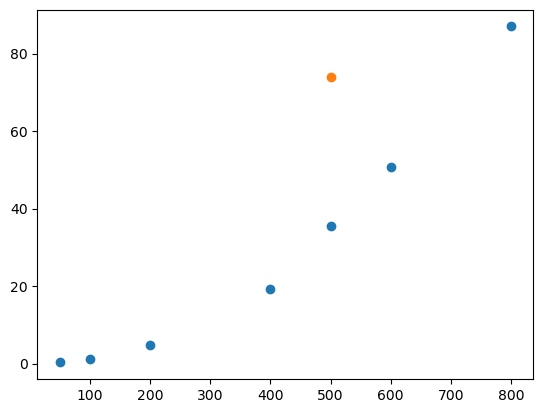

In [31]:
pickle_loci_1 = [50,100,200,400,500,600,800]
pickle_time_1 = [0.3,1.1,4.8,19.3,35.4, 50.7,87]

pickle_loci_2 = [500]
pickle_time_2 = [74]

plt.scatter(pickle_loci_1,pickle_time_1)
plt.scatter(pickle_loci_2,pickle_time_2)
plt.show()


Read pickle file ...  kmer_R2_dict_illumina_0-499.pkl     Duration: 0:00:00.093333


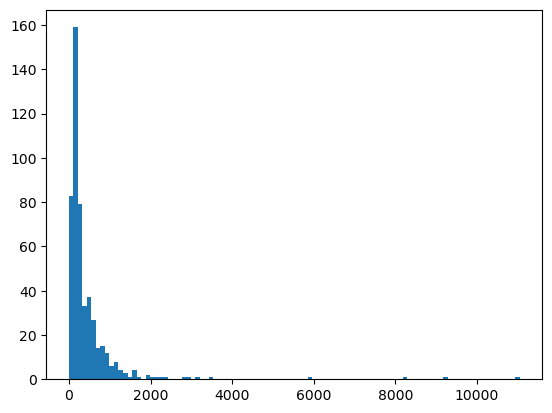

In [29]:
# read pickle file:
mydict = read_pickle(path, 'kmer_R2_dict_illumina_0-999.pkl')

locus_len = []
for i,locus in enumerate(mydict.keys()):
    locus_len.append(len(mydict[locus].keys()))

    
plt.hist(locus_len,bins=100)
plt.show()


In [9]:
start_time = datetime.now()

# get the R2 values:
cnt = 0
kmer_R2_PR = []
for i, locus in enumerate(illumina_R2_dict.keys()):
    for kmer in illumina_R2_dict[locus].keys():
        # add a 0 to each vector:
        illumina_R2_dict[locus][kmer].append(0)
        fasta_R2_dict[locus][kmer].append(0)
        y = illumina_R2_dict[locus][kmer]
        x = fasta_R2_dict[locus][kmer]
        cnt += 1
#        if cnt < 10:
#            print(illumina_R2_dict[locus][kmer])
#            print(fasta_R2_dict[locus][kmer])

        if i < 500:
            if len(x)>2 and len(y)>2 and np.sum(x)>0 and np.sum(y)>0:
                # Pearson's R:
                PearsonsR = stats.pearsonr(x, y)
                kmer_R2_PR.append(np.square(PearsonsR[0]))
        
print(datetime.now()-start_time)    

0:03:39.953221


In [ ]:
start_time = datetime.now()

# find invaiant kmers
cnt = 0
for i, locus in enumerate(fasta_R2_dict.keys()):
    for kmer in fasta_R2_dict[locus].keys():
        x = fasta_R2_dict[locus][kmer]
        # check if all entries are identical, if they are, then this is n invariant kmer
        x_set = set(x)
        if len(x_set)==1:
            print('we found an invariant kmer')
        
        x0 = x[0]
        for i in range(1,len(x)):
            if x[i] != x0:
                break
                
        
        cnt += 1
#        if cnt < 10:
#            print(illumina_R2_dict[locus][kmer])
#            print(fasta_R2_dict[locus][kmer])

        
print(datetime.now()-start_time)





In [ ]:
from operator import itemgetter
 
# initializing dictionary
original_dict = {1: 'a', 2: 'b', 3: 'c', 4: 'd'}
#keys_to_extract = {'a', 'b'}
#keys_to_extract = {1, 2}
keys_to_extract = set(np.arange(1,3))
 
subset_dict = dict(
    zip(keys_to_extract, itemgetter(*keys_to_extract)(original_dict)))
 
# Printing dictionary
print("Subset dictionary using itemgetter() from the operator Module:", subset_dict)


In [13]:
aa = np.zeros((10000, 48))

print(1000000*48*8/1024/1024)


366.2109375


In [ ]:
file_list = []
for genome in genome_list:
    f = open(filename(genome), 'r')
    file_list.append(f)
    
g = file_list[i]
g.readline()

for i, genome in enumerate(genome_list):
    close(file_list[i])

    